# We saw some interesting composite motifs for the CTCF short task
## What is the distribution of these motifs like? Do they correlate with other genomic features (like above)? Do they lie in CUT&RUN-specific peaks?

In [1]:
import os
os.chdir('/home/katie/bp_repo/reports/')

from util import import_shap_scores, import_peak_table
from util import trim_motif_by_ic
from util import figure_to_vdom_image
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from IPython.display import display
import tqdm
tqdm.tqdm_notebook()

plt.rcParams['figure.dpi'] = 130

/tmp/ipykernel_134288/1313173272.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm.tqdm_notebook()


0it [00:00, ?it/s]

In [2]:
# Plotting defaults
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

In [4]:
# CTCF short task motif hits

# Define parameters/fetch arguments
motif_hits_path = ['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed']
print("SHORT Motif hits path: %s" % motif_hits_path)

SHORT Motif hits path: ['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed']


In [7]:
# Load in assay peaks
assay_bed_paths = ['/home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz',
                   '/home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz',
                   '/home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz',
                   '/home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz']
print("ATAC peaks path: %s" % assay_bed_paths[0])
print("DNASE peaks path: %s" % assay_bed_paths[1])
print("ac histone marks: %s" % assay_bed_paths[2])
print("me3 histone marks: %s" % assay_bed_paths[3])

ATAC peaks path: /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz
DNASE peaks path: /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz
ac histone marks: /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz
me3 histone marks: /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz


In [8]:
# Import motif hits
hits = import_peak_table(motif_hits_path)          # 295,274 hits

# Isolate to composite motifs
hits_pattern_3 = hits[hits.name == '0_3']           # 1,496 hits and peak lengths are 9
hits_pattern_5 = hits[hits.name == '0_5']           # 1,167 hits and peak lengths are 9 only

# Import assay peaks
atac_peak_table = import_peak_table([assay_bed_paths[0]])  # 278,564 peaks and TONS of peak lengths
dnase_peak_table = import_peak_table([assay_bed_paths[1]]) # 143,283 peaks and TONS of peak lengths
ac_peak_table = import_peak_table([assay_bed_paths[2]])    # 129,753 peaks and TONS of peak lengths
me3_peak_table = import_peak_table([assay_bed_paths[3]])   # 27,884 peaks and TONS of peak lengths

### DNase-seq overlap

In [12]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/max_motif_hits_dnase_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_minfl150_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/min_motif_hits_dnase_overlap')

max_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/max_motif_hits_dnase_overlap',  # 69,959 overlaps
                                sep='\t', header=None)

In [14]:
pattern_3_dnase_overlap = max_dnase_overlap[max_dnase_overlap.iloc[:,3] == '0_3']            # 64,193 core overlaps
pattern_5_dnase_overlap = max_dnase_overlap[max_dnase_overlap.iloc[:,3] == '0_5']            # 66,091 core overlaps

In [15]:
len(pattern_3_dnase_overlap) / len(hits_pattern_3)  # % of max task hits overlapping >0 DNase peak ONLY FOR CORE MOTIF
# and i did check, core_max_dnase_overlap is a SUBSET of the original df, core_hits_max (check using merge function)

0.7159090909090909

In [16]:
len(pattern_5_dnase_overlap) / len(hits_pattern_5)  # % of min task hits overlapping >0 DNase peak ONLY FOR CORE MOTIF

0.7746358183376179

### ATAC-seq overlap

In [17]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/max_motif_hits_atac_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_minfl150_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/min_motif_hits_atac_overlap')

max_atac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/max_motif_hits_atac_overlap',  # 78,914 overlaps
                                sep='\t', header=None)

In [18]:
pattern_3_atac_overlap = max_atac_overlap[max_atac_overlap.iloc[:,3] == '0_3']            # 64,193 core overlaps
pattern_5_atac_overlap = max_atac_overlap[max_atac_overlap.iloc[:,3] == '0_5']            # 66,091 core overlaps

In [19]:
len(pattern_3_atac_overlap) / len(hits_pattern_3)  # % of max task hits overlapping >0 DNase peak ONLY FOR CORE MOTIF

0.8703208556149733

In [20]:
len(pattern_5_atac_overlap) / len(hits_pattern_5)  # % of min task hits overlatacg >0 DNase peak ONLY FOR CORE MOTIF

0.8774635818337618

#### ATAC-seq fragment length correlation

In [14]:
# TODO
# ...but also idk what todo smh send help

### H3K27ac overlap

In [22]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/max_motif_hits_h3k27ac_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_minfl150_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/min_motif_hits_h3k27ac_overlap')

max_ac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/max_motif_hits_h3k27ac_overlap',  # 55,944 overlaps
                                sep='\t', header=None)

In [23]:
pattern_3_ac_overlap = max_ac_overlap[max_ac_overlap.iloc[:,3] == '0_3']            # 64,193 core overlaps
pattern_5_ac_overlap = max_ac_overlap[max_ac_overlap.iloc[:,3] == '0_5']            # 66,091 core overlaps

In [24]:
len(pattern_3_ac_overlap) / len(hits_pattern_3)  # % of max task hits overlapping >0 DNase peak ONLY FOR CORE MOTIF

0.3609625668449198

In [25]:
len(pattern_5_ac_overlap) / len(hits_pattern_5)  # % of min task hits overlapping >0 DNase peak ONLY FOR CORE MOTIF

0.26906598114824337

### H3K4me3 overlap

In [26]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/max_motif_hits_h3k4me3_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_minfl150_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/min_motif_hits_h3k4me3_overlap')

max_me_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/max_motif_hits_h3k4me3_overlap',  # 10,917 overlaps
                                sep='\t', header=None)

In [27]:
pattern_3_me_overlap = max_me_overlap[max_me_overlap.iloc[:,3] == '0_3']            # 64,193 core overlaps
pattern_5_me_overlap = max_me_overlap[max_me_overlap.iloc[:,3] == '0_5']            # 66,091 core overlaps

In [28]:
len(pattern_3_me_overlap) / len(hits_pattern_3)  # % of max task hits overlapping >0 DNase peak ONLY FOR CORE MOTIF

0.2446524064171123

In [29]:
len(pattern_5_me_overlap) / len(hits_pattern_5)  # % of min task hits overlapping >0 DNase peak ONLY FOR CORE MOTIF

0.1662382176520994

### CUT&RUN peaks overlap

In [39]:
# run this once to find peaks unique to cutnrun, and separately, unique to chipseq
#os.system('bedtools intersect -v -a /home/katie/bp_repo/research/data/cutnrun/CTCF/CTCF.bed -b /home/katie/bp_repo/research/data/chip-seq/CTCF/CTCF.bed > /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_cutnrun_no_chip_overlap')
#os.system('bedtools intersect -v -a /home/katie/bp_repo/research/data/chip-seq/CTCF/CTCF.bed -b /home/katie/bp_repo/research/data/cutnrun/CTCF/CTCF.bed > /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_chip_no_cutnrun_overlap') 
cutnrun_unique = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_cutnrun_no_chip_overlap'])
chipseq_unique = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_chip_no_cutnrun_overlap'])



0

In [48]:
# run this once to intersect short task motif hits with various peaks
#os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed -b /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_cutnrun_no_chip_overlap > /home/katie/bp_repo/reports/katie_notebooks/TASK_5/hits_overlap_UNIQUE_cutnrun')
#os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed -b /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_chip_no_cutnrun_overlap > /home/katie/bp_repo/reports/katie_notebooks/TASK_5/hits_overlap_UNIQUE_chipseq')
#os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed -b /home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_cutnrun_with_any_chip_overlap > /home/katie/bp_repo/reports/katie_notebooks/TASK_5/hits_overlap_SHARED_cutnrun')


hits_overlap_cutnrun_unique = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/TASK_5/hits_overlap_UNIQUE_cutnrun'])
hits_overlap_cutnrun_shared = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/TASK_5/hits_overlap_SHARED_cutnrun'])

#hits_overlap_chipseq = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/TASK_5/hits_overlap_UNIQUE_chipseq'])



In [49]:
hits_overlap_cutnrun_shared.shape

(190550, 17)

In [50]:
hits_overlap_cutnrun_unique.shape

(102579, 17)

In [53]:
hits_overlap_cutnrun_unique

,chrom,peak_start,peak_end,name,score,strand,signal,pval,qval,summit_offset,i0,i1,i2,i3,i4,i5,summit
0,chr3,93470560,93470568,0_1,-,0,0.684786,0.819272,0.090691,0.087598,0.196782,0.000321,0.978495,0.045886,0.085443,0.194620,9.347056e+07
1,chr3,93470571,93470579,0_1,+,0,0.287351,0.403737,0.044693,0.034518,0.077646,0.000150,0.978495,0.020570,0.009494,0.001582,9.347057e+07
2,chr3,93470644,93470652,0_1,-,0,0.280833,0.488077,0.054029,0.032117,0.158429,0.000164,0.978495,0.022152,0.018987,0.085443,9.347064e+07
3,chr3,93470686,93470694,0_1,-,0,0.278070,0.341024,0.037751,0.044895,0.222728,0.000495,1.000000,0.281646,0.229430,0.208861,9.347069e+07
4,chr5,77867284,77867297,0_0,+,58,0.637077,0.655391,0.098392,0.064832,0.389630,0.000186,0.400000,0.005862,0.033998,0.398593,7.786728e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102574,chr7,140659881,140659889,0_1,+,54231,0.315166,0.355343,0.066730,0.055033,0.399561,0.000525,1.000000,0.425633,0.699367,0.751582,1.406599e+08
102575,chr8,132905115,132905123,0_1,+,54232,0.301045,0.305852,0.049900,0.043562,0.274036,0.000518,1.000000,0.393987,0.392405,0.390823,1.329051e+08
102576,chr8,132905142,132905150,0_1,-,54232,0.561276,0.561276,0.091573,0.069559,0.272732,0.000332,0.978495,0.049051,0.207278,0.607595,1.329051e+08
102577,chr8,132905219,132905227,0_1,-,54232,0.388987,0.388987,0.063463,0.072487,0.394660,0.000493,1.000000,0.275316,0.631329,0.795886,1.329052e+08


In [51]:
hits_overlap_cutnrun_shared

,chrom,peak_start,peak_end,name,score,strand,signal,pval,qval,summit_offset,i0,i1,i2,i3,i4,i5,summit
0,chr10,101012977,101012985,0_1,+,2,0.340524,0.340524,0.016527,0.041204,0.145653,0.000403,0.978495,0.109177,0.053797,0.036392,1.010130e+08
1,chr10,101012993,101013006,0_0,-,2,2.572299,2.827186,0.137214,0.248276,0.553211,0.000324,0.989011,0.029308,0.568581,0.996483,1.010130e+08
2,chr10,101013036,101013044,0_1,+,2,0.866454,0.994000,0.048243,0.141736,0.266541,0.000498,1.000000,0.287975,0.349684,0.367089,1.010130e+08
3,chr10,101013048,101013056,0_1,-,2,0.798527,1.004887,0.048771,0.170962,0.302790,0.000498,1.000000,0.287975,0.382911,0.431962,1.010130e+08
4,chr10,101013076,101013089,0_0,-,2,1.895521,4.127681,0.200332,0.083185,0.362674,0.000203,0.401106,0.005862,0.023447,0.143025,1.010131e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190545,chr1,3727526,3727534,0_1,+,54196,0.789947,0.931917,0.047237,0.089717,0.121520,0.000289,0.978495,0.036392,0.025316,0.033228,3.727526e+06
190546,chr1,3727539,3727552,0_0,+,54196,0.554288,0.672163,0.034070,0.047531,0.268280,0.000174,0.400000,0.005862,0.016413,0.063306,3.727539e+06
190547,chr1,3727620,3727633,0_0,+,54196,0.416285,0.499540,0.025320,0.041934,0.320672,0.000315,0.989011,0.028136,0.043376,0.109027,3.727620e+06
190548,chr10,76903092,76903100,0_1,-,54224,0.498722,0.499037,0.083614,0.077798,0.258697,0.000525,1.000000,0.425633,0.318038,0.281646,7.690309e+07


### ChIP-seq peaks overlap

## Graphing

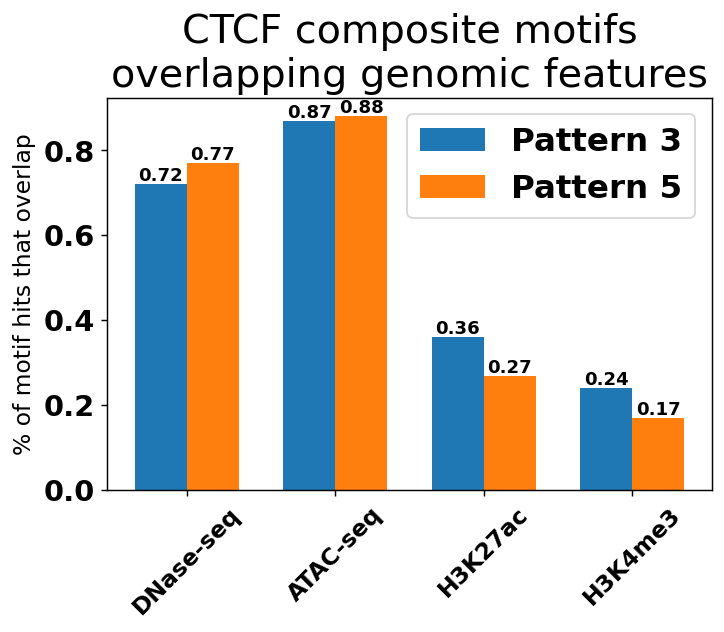

In [35]:
# order: ( % of short motif hits overlapping assay, with assay order DNASE; ATAC; ac; me, 
#          % of long motif hits overlapping assay, with assay order DNASE; ATAC; ac; me)
pattern_3_stats = (len(pattern_3_dnase_overlap) / len(hits_pattern_3),
                 len(pattern_3_atac_overlap) / len(hits_pattern_3),
                 len(pattern_3_ac_overlap) / len(hits_pattern_3),
                 len(pattern_3_me_overlap) / len(hits_pattern_3))
pattern_5_stats = (len(pattern_5_dnase_overlap) / len(hits_pattern_5),
              len(pattern_5_atac_overlap) / len(hits_pattern_5),
              len(pattern_5_ac_overlap) / len(hits_pattern_5),
              len(pattern_5_me_overlap) / len(hits_pattern_5))

pattern_3_stats = [round(stat, 2) for stat in pattern_3_stats]
pattern_5_stats = [round(stat, 2) for stat in pattern_5_stats]

ind = np.arange(len(pattern_3_stats))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(dpi=130)
rects1 = ax.bar(ind - width/2, pattern_3_stats, width, 
                label='Pattern 3')
rects2 = ax.bar(ind + width/2, pattern_5_stats, width,
                label='Pattern 5')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% of motif hits that overlap', fontsize=13)
ax.set_title('CTCF composite motifs\noverlapping genomic features')
ax.set_xticks(ind)
ax.set_xticklabels(('DNase-seq', 'ATAC-seq', 'H3K27ac', 'H3K4me3'), rotation=45, fontsize=13)
ax.legend(loc='upper right')

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, -0.5),  # use -0.5 point offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "center")
autolabel(rects2, "center")

plt.show()

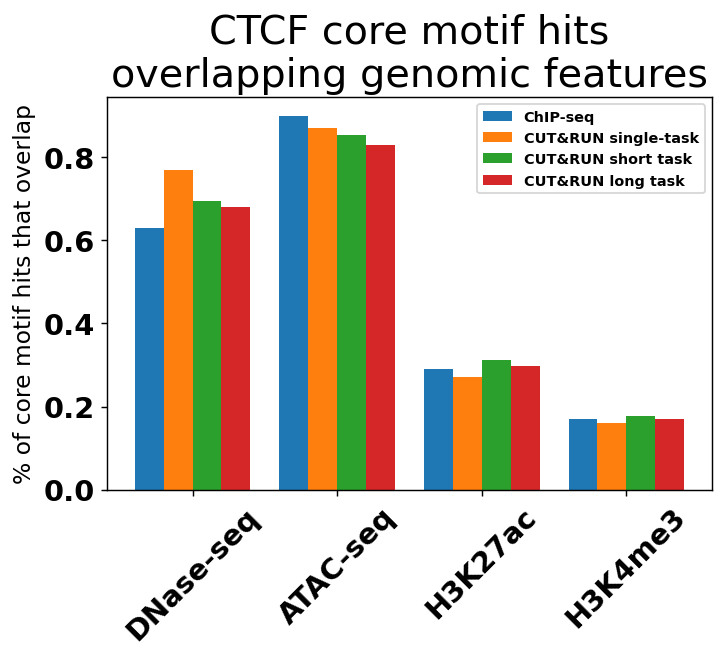

In [52]:
X = ['DNase-seq', 'ATAC-seq', 'H3K27ac', 'H3K4me3']
chips = chipseq_stats = (0.63, 0.90, 0.29, 0.17)
cuts = (0.77, 0.87, 0.27, 0.16)
shorts = (len(core_max_dnase_overlap) / len(core_hits_max),
                 len(core_max_atac_overlap) / len(core_hits_max),
                 len(core_max_ac_overlap) / len(core_hits_max),
                 len(core_max_me_overlap) / len(core_hits_max))
longs = (len(core_min_dnase_overlap) / len(core_hits_min),
              len(core_min_atac_overlap) / len(core_hits_min),
              len(core_min_ac_overlap) / len(core_hits_min),
              len(core_min_me_overlap) / len(core_hits_min)) 
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.3, chips, 0.2, label = 'ChIP-seq')
plt.bar(X_axis - 0.1, cuts, 0.2, label = 'CUT&RUN single-task')
plt.bar(X_axis + 0.1, shorts, 0.2, label = 'CUT&RUN short task')
plt.bar(X_axis + 0.3, longs, 0.2, label = 'CUT&RUN long task')
  
plt.xticks(X_axis, X, rotation=45)
plt.ylabel("% of core motif hits that overlap", fontsize=13)
plt.title("CTCF core motif hits\noverlapping genomic features")
plt.legend(fontsize=8)
plt.show()

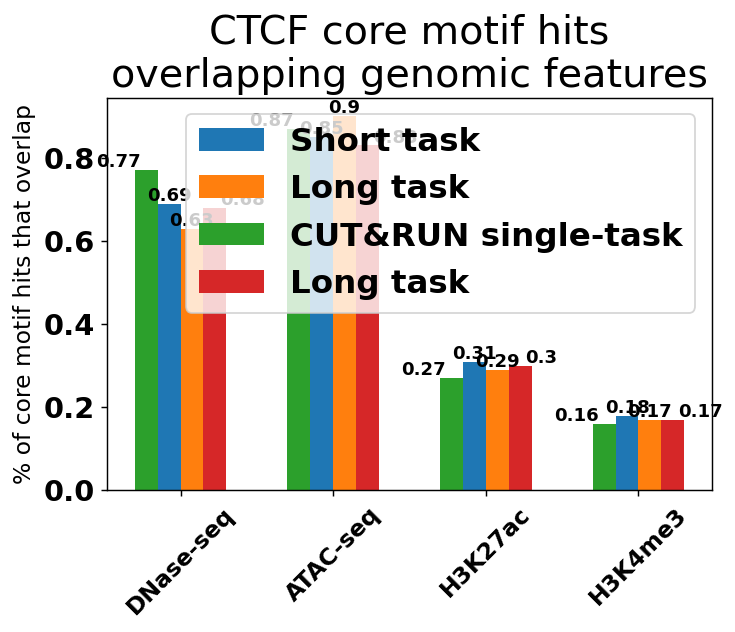

In [48]:
# order: ( % of short motif hits overlapping assay, with assay order DNASE; ATAC; ac; me, 
#          % of chipseq motif hits overlapping assay, with assay order DNASE; ATAC; ac; me)
#          % of CUT&RUN motif hits overlapping assay, with assay order DNASE; ATAC; ac; me, 
#          % of long motif hits overlapping assay, with assay order DNASE; ATAC; ac; me)
short_stats = (len(core_max_dnase_overlap) / len(core_hits_max),
                 len(core_max_atac_overlap) / len(core_hits_max),
                 len(core_max_ac_overlap) / len(core_hits_max),
                 len(core_max_me_overlap) / len(core_hits_max))
long_stats = (len(core_min_dnase_overlap) / len(core_hits_min),
              len(core_min_atac_overlap) / len(core_hits_min),
              len(core_min_ac_overlap) / len(core_hits_min),
              len(core_min_me_overlap) / len(core_hits_min))
chipseq_stats = (0.63, 0.90, 0.29, 0.17)
cutnrun_stats = (0.77, 0.87, 0.27, 0.16)

short_stats = [round(stat, 2) for stat in short_stats]
long_stats = [round(stat, 2) for stat in long_stats]

ind = np.arange(len(short_stats))  # the x locations for the groups
width = 0.15  # the width of the bars

fig, ax = plt.subplots(dpi=130)
rects1 = ax.bar(ind - width/2, short_stats, width, 
                label='Short task')
rects2 = ax.bar(ind + width/2, chipseq_stats, width,
                label='Long task')
rects3 = ax.bar(ind - 1.5*width, cutnrun_stats, width, 
                label='CUT&RUN single-task')
rects4 = ax.bar(ind + 1.5*width, long_stats, width,
                label='Long task')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% of core motif hits that overlap', fontsize=13)
ax.set_title('CTCF core motif hits\noverlapping genomic features')
ax.set_xticks(ind)
ax.set_xticklabels(('DNase-seq', 'ATAC-seq', 'H3K27ac', 'H3K4me3'), rotation=45, fontsize=13)
ax.legend(loc='upper right')

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, -0.5),  # use -0.5 point offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "center")
autolabel(rects2, "center")
autolabel(rects3, "left")
autolabel(rects4, "right")

plt.show()